In [1]:
%load_ext lab_black
%load_ext watermark

import re, os, copy, math, subprocess, glob, sys, random, json
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
import sklearn
import matplotlib

matplotlib.rcParams["figure.dpi"] = 120
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import mixture
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve

from scipy.stats import theilslopes

marker_list = ["D", "P", "o", "*", ">", "<", "^", "v", "s"] * 100

diag_order = ["CD", "UC", "nonIBD"]

pal2use = {"CD": "darkred", "nonIBD": "dodgerblue", "UC": "goldenrod"}

!pwd
%watermark -a "Daniel Peterson" -dntu -iv

/home/daniel/Dropbox/bile_acid_paper
Author: Daniel Peterson

Last updated: 2024-11-07 20:41:36

scipy     : 1.10.0
re        : 2.2.1
pandas    : 1.5.3
numpy     : 1.23.5
seaborn   : 0.12.2
sklearn   : 1.0.2
matplotlib: 3.7.1
json      : 2.0.9
sys       : 3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]



# Read in bai data

In [2]:
Franzosa_df = pd.read_csv(
    "paper_data/Franzosa_2018_bai_results.csv",
    low_memory=False,
)
Franzosa_df["Study"] = "Franzosa_2018"
print(Franzosa_df.shape)
Franzosa_df.head()

(187, 6730)


,Sample,geo_loc,participant,read_len,age,diagnosis,fcal,abx,immunosuppressant,mesalamine,...,EC_baiE,baib,baicd,baie,baif,baig,baih,baii,uniref90_bai_mean,Study
0,SRR6468499,Netherlands,UMCG4000898_NLIBD,197.0,75.0,UC,NaN,False,False,False,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000000,Franzosa_2018
1,SRR6468500,Netherlands,UMCG4081271_NLIBD,197.0,28.0,UC,130.000000,False,False,True,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000000,Franzosa_2018
2,SRR6468502,USA,PRISM_7941_PRISM,199.0,32.0,CD,260.760538,False,True,False,...,4.265,4.503,4.411,4.265,0.0,3.688,4.382,0.0,3.035571,Franzosa_2018
3,SRR6468503,Netherlands,LLDeep_0012_NLIBD,194.0,32.0,nonIBD,17.800000,False,NaN,NaN,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000000,Franzosa_2018
4,SRR6468505,USA,PRISM_8878_PRISM,197.0,24.0,CD,NaN,False,False,False,...,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.0,0.000000,Franzosa_2018


In [3]:
hmp2_df = pd.read_csv(
    "paper_data/HMP2_bai_results.csv",
    low_memory=False,
).rename(columns={"Participant ID": "participant"})
hmp2_df["Study"] = "HMP2"
print(hmp2_df.shape)

LP_runinfo_df = pd.read_csv("paper_data/Lloyd_price_2019_SraRunInfo.csv")
LP_runinfo_df = LP_runinfo_df[
    (LP_runinfo_df["LibrarySource"] == "METAGENOMIC")
    & (LP_runinfo_df["LibraryStrategy"] == "WGS")
    & (LP_runinfo_df["ScientificName"] == "human gut metagenome")
].copy()
LP_runinfo_df["Sample"] = LP_runinfo_df["LibraryName"].apply(
    lambda x: re.sub("_MGX", "", x)
)
print(LP_runinfo_df.shape)

hmp2_df = hmp2_df.merge(
    LP_runinfo_df[["Sample", "spots"]],
    how="left",
)
print(hmp2_df.shape)

hmp2_derep_df = (
    hmp2_df.sort_values("week_num", ascending=True)
    .drop_duplicates("participant")
    .rename(columns={"prop_DCA_CA": "prop_secondary"})
)

hmp2_derep_df["DCA:CA"] = (hmp2_derep_df["deoxycholate"] + 1) / (
    hmp2_derep_df["cholate"] + 1
)
hmp2_derep_df["LCA:CDCA"] = (hmp2_derep_df["lithocholate"] + 1) / (
    hmp2_derep_df["chenodeoxycholate"] + 1
)
hmp2_derep_df["DCA:CA_log10"] = hmp2_derep_df["DCA:CA"].apply(math.log10)
hmp2_derep_df["LCA:CDCA_log10"] = hmp2_derep_df["LCA:CDCA"].apply(math.log10)

print(hmp2_derep_df.shape)
hmp2_derep_df.head()

(241, 33)
(1338, 47)
(241, 34)
(96, 38)


,External ID,participant,week_num,diagnosis,lithocholate,chenodeoxycholate,deoxycholate,cholate,glycolithocholate,glycochenodeoxycholate,...,placeholder,Bai_mean,Bai_min,Bai_num_genes,Study,spots,DCA:CA,LCA:CDCA,DCA:CA_log10,LCA:CDCA_log10
83,HSM6XRQB,H4017,0.0,CD,26285108.0,4261293.0,86322504.0,8954952.0,362036.0,2570269.0,...,-7.024901,-6.806966,-9.0,7,HMP2,10590116,9.639638,6.168340,0.984061,0.790168
216,PSM6XBRK,P6009,0.0,CD,21469648.0,881063.0,52375143.0,2795576.0,525008.0,596902.0,...,-7.026960,-7.969737,-9.0,3,HMP2,10640452,18.735003,24.367865,1.272654,1.386817
185,MSM79H8D,M2075,0.0,nonIBD,30072456.0,4031392.0,81551748.0,4655229.0,112367.0,1055295.0,...,-7.214592,-7.315876,-9.0,5,HMP2,16390479,17.518307,7.459570,1.243492,0.872714
30,CSM67UH7,C3022,0.0,nonIBD,43389415.0,1972635.0,97595139.0,3501927.0,633351.0,846725.0,...,-7.090499,-7.708146,-9.0,4,HMP2,12316821,27.868974,21.995653,1.445121,1.342337
239,PSMA265X,P6038,0.0,UC,21718922.0,5333737.0,42115958.0,10603288.0,73963.0,1231139.0,...,-7.036889,-8.312182,-9.0,2,HMP2,10886523,3.971971,4.071989,0.599006,0.609807


In [4]:
combo_df = pd.concat([Franzosa_df, hmp2_derep_df])
combo_df["secondary_BA"] = combo_df["prop_secondary"] > 0.5
print(combo_df.shape)
combo_df

(283, 6750)


,Sample,geo_loc,participant,read_len,age,diagnosis,fcal,abx,immunosuppressant,mesalamine,...,glycocholate,taurolithocholate,taurochenodeoxycholate,taurodeoxycholate,taurohyodeoxycholate/tauroursodeoxycholate,tauro-alpha-muricholate/tauro-beta-muricholate,taurocholate,LCA:CDCA,LCA:CDCA_log10,secondary_BA
0,SRR6468499,Netherlands,UMCG4000898_NLIBD,197.0,75.0,UC,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
1,SRR6468500,Netherlands,UMCG4081271_NLIBD,197.0,28.0,UC,130.000000,False,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,SRR6468502,USA,PRISM_7941_PRISM,199.0,32.0,CD,260.760538,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,SRR6468503,Netherlands,LLDeep_0012_NLIBD,194.0,32.0,nonIBD,17.800000,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,SRR6468505,USA,PRISM_8878_PRISM,197.0,24.0,CD,NaN,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,HSM6XRVW,NaN,H4014,NaN,NaN,CD,NaN,NaN,NaN,NaN,...,52709788.0,2306868.0,373587878.0,99856233.0,22389491.0,2777137.0,190382741.0,0.235162,-0.628633,False
140,MSM6J2OP,NaN,M2026,NaN,NaN,UC,NaN,NaN,NaN,NaN,...,56258024.0,1073501.0,86480616.0,15484948.0,8083119.0,553976.0,95315741.0,1.233177,0.091025,False
19,CSM7KOLA,NaN,C3010,NaN,NaN,CD,NaN,NaN,NaN,NaN,...,26075023.0,501738.0,55820198.0,39093433.0,1624175.0,344978.0,46769581.0,0.508121,-0.294033,False
20,CSM7KOMT,NaN,C3011,NaN,NaN,UC,NaN,NaN,NaN,NaN,...,623777.0,514465.0,156656.0,537511.0,50802.0,7375.0,502579.0,13.649255,1.135109,False


In [5]:
combo_df.groupby(["Study", "diagnosis"])["participant"].nunique()

Study          diagnosis
Franzosa_2018  CD           75
               UC           59
               nonIBD       53
HMP2           CD           44
               UC           28
               nonIBD       24
Name: participant, dtype: int64

# BA metabolomics

In [6]:
hmp2_derep_df["DCA:CA"] = (hmp2_derep_df["deoxycholate"] + 1) / (
    hmp2_derep_df["cholate"] + 1
)
hmp2_derep_df["LCA:CDCA"] = (hmp2_derep_df["lithocholate"] + 1) / (
    hmp2_derep_df["chenodeoxycholate"] + 1
)
hmp2_derep_df["DCA:CA_log10"] = hmp2_derep_df["DCA:CA"].apply(math.log10)
hmp2_derep_df["LCA:CDCA_log10"] = hmp2_derep_df["LCA:CDCA"].apply(math.log10)

hmp2_derep_df["CA_log10"] = hmp2_derep_df["cholate"].apply(lambda x: math.log10(x + 1))
hmp2_derep_df["GCA_log10"] = hmp2_derep_df["glycocholate"].apply(
    lambda x: math.log10(x + 1)
)
hmp2_derep_df["TCA_log10"] = hmp2_derep_df["taurocholate"].apply(
    lambda x: math.log10(x + 1)
)

hmp2_derep_df["DCA_log10"] = hmp2_derep_df["deoxycholate"].apply(
    lambda x: math.log10(x + 1)
)
hmp2_derep_df["GDCA_log10"] = hmp2_derep_df["glycodeoxycholate"].apply(
    lambda x: math.log10(x + 1)
)
hmp2_derep_df["TDCA_log10"] = hmp2_derep_df["taurodeoxycholate"].apply(
    lambda x: math.log10(x + 1)
)

hmp2_derep_df["GDCA:GCA_log10"] = (hmp2_derep_df["glycodeoxycholate"] + 1) / (
    hmp2_derep_df["glycocholate"] + 1
)
hmp2_derep_df["TDCA:TCA_log10"] = (hmp2_derep_df["taurodeoxycholate"] + 1) / (
    hmp2_derep_df["taurocholate"] + 1
)

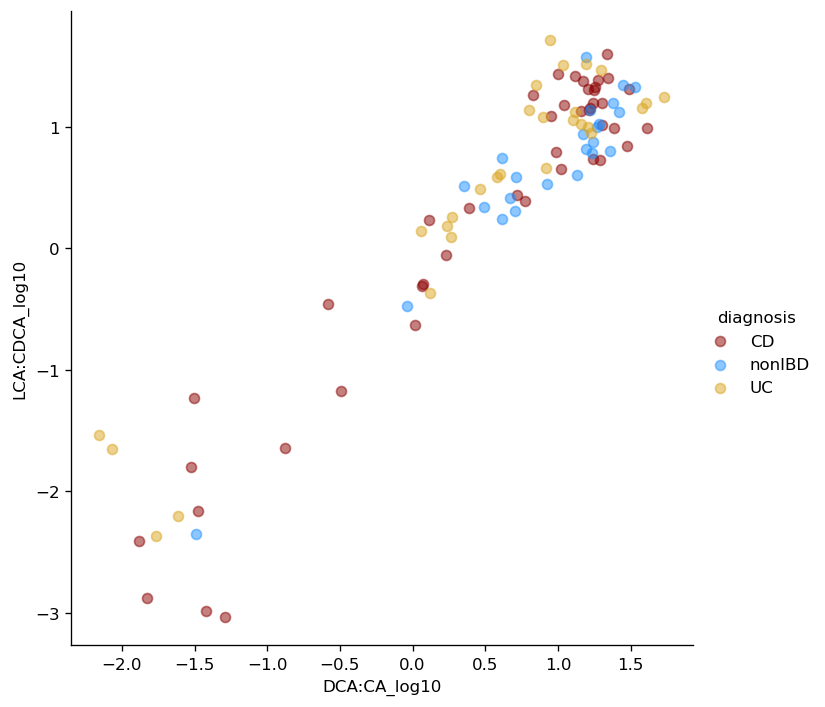

In [7]:
g = sns.FacetGrid(
    data=hmp2_derep_df,
    hue="diagnosis",
    height=6,
    aspect=1,
    palette=pal2use,
    sharex=True,
    sharey=True,
)
g = g.map(plt.scatter, "DCA:CA_log10", "LCA:CDCA_log10", alpha=0.5)
g.add_legend()

In [8]:
combo_df[
    [
        "DCA:CDCA",
        "DCA:CA",
        "DCA_log10",
        "CDCA_log10",
        "CA_log10",
        "DCA:CA_log10",
        "DCA:CDCA_log10",
        "lithocholate",
        "chenodeoxycholate",
        "deoxycholate",
        "cholate",
        "glycolithocholate",
        "glycochenodeoxycholate",
        "glycodeoxycholate",
        "glycoursodeoxycholate",
        "glycocholate",
        "taurolithocholate",
        "taurochenodeoxycholate",
        "taurodeoxycholate",
        "taurocholate",
    ]
]

,DCA:CDCA,DCA:CA,DCA_log10,CDCA_log10,CA_log10,DCA:CA_log10,DCA:CDCA_log10,lithocholate,chenodeoxycholate,deoxycholate,cholate,glycolithocholate,glycochenodeoxycholate,glycodeoxycholate,glycoursodeoxycholate,glycocholate,taurolithocholate,taurochenodeoxycholate,taurodeoxycholate,taurocholate
0,119.040841,42.075608,4.609891,2.534195,2.985861,1.624030,2.075696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,23866.800000,175.447315,4.377794,0.000000,2.133647,2.244147,4.377794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,48.650258,8.923603,4.650921,2.963836,3.700381,0.950540,1.687085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56132.500000,197.030113,4.749214,0.000000,2.454682,2.294533,4.749214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.640725,1.632146,4.654647,3.588667,4.441888,0.212759,1.065980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,NaN,1.044486,NaN,NaN,NaN,0.018903,NaN,12157692.0,51699281.0,87222748.0,83507801.0,497770.0,68268921.0,47058127.0,9934302.0,52709788.0,2306868.0,373587878.0,99856233.0,190382741.0
140,NaN,1.835187,NaN,NaN,NaN,0.263680,NaN,26524563.0,21509129.0,115737695.0,63065871.0,105355.0,44841569.0,10471696.0,8223607.0,56258024.0,1073501.0,86480616.0,15484948.0,95315741.0
19,NaN,1.174190,NaN,NaN,NaN,0.069738,NaN,5757021.0,11330023.0,60410132.0,51448335.0,237615.0,17000624.0,23855933.0,865913.0,26075023.0,501738.0,55820198.0,39093433.0,46769581.0
20,NaN,6.304831,NaN,NaN,NaN,0.799673,NaN,65640986.0,4809125.0,213947949.0,33933967.0,379498.0,594058.0,1780330.0,10350.0,623777.0,514465.0,156656.0,537511.0,502579.0


# Stats

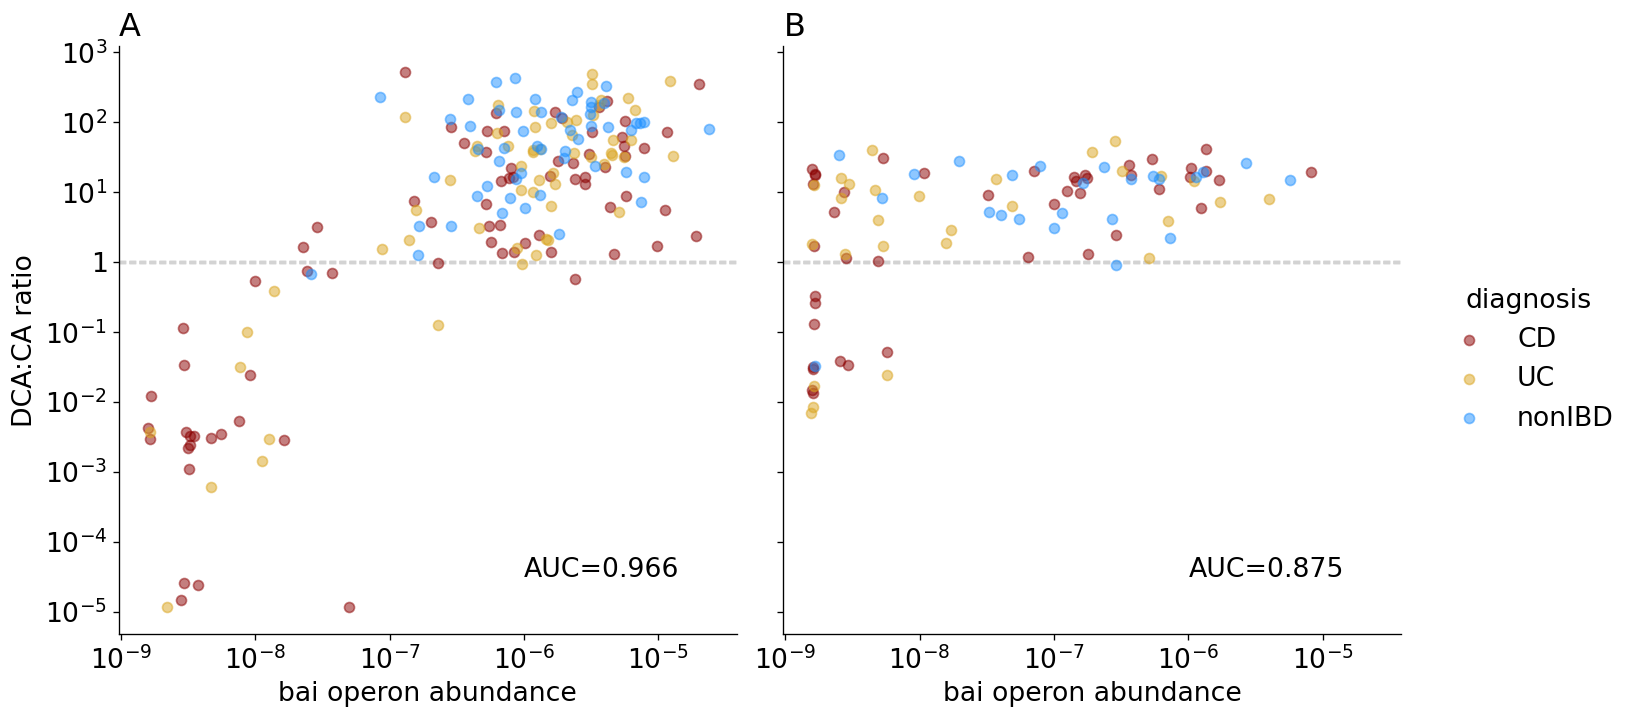

In [9]:
plt.close()
plt.rcParams.update({"font.size": 16})

plot_df = combo_df.rename(
    columns={"Bai_mean": "bai operon abundance", "DCA:CA_log10": "DCA:CA ratio"}
)

g = sns.FacetGrid(
    data=plot_df,
    hue="diagnosis",
    hue_order=["CD", "UC", "nonIBD"],
    col="Study",
    height=6,
    aspect=1,
    palette=pal2use,
    sharex=True,
    sharey=True,
)
g = g.map(plt.scatter, "bai operon abundance", "DCA:CA ratio", alpha=0.5)
g.add_legend()
g.set_titles("")


g.map(plt.axhline, y=0, color="lightgray", dashes=(2, 1), zorder=0, linewidth=2)

axes = g.axes.flatten()
axes[0].set_title("A", loc="left")
axes[0].text(s="AUC=0.966", x=-6, y=-4.5)
axes[1].set_title("B", loc="left")
axes[1].text(s="AUC=0.875", x=-6, y=-4.5)

reformatted_x_labels = [
    r"$\mathregular{10^{-9}}$",
    r"$\mathregular{10^{-8}}$",
    r"$\mathregular{10^{-7}}$",
    r"$\mathregular{10^{-6}}$",
    r"$\mathregular{10^{-5}}$",
]

reformatted_y_labels = [
    r"$\mathregular{10^{-5}}$",
    r"$\mathregular{10^{-4}}$",
    r"$\mathregular{10^{-3}}$",
    r"$\mathregular{10^{-2}}$",
    r"$\mathregular{10^{-1}}$",
    r"$\mathregular{1}}$",
    r"$\mathregular{10^{1}}$",
    r"$\mathregular{10^{2}}$",
    r"$\mathregular{10^{3}}$",
]

for cur_ax in axes:
    cur_ax.set_xticks([-9, -8, -7, -6, -5], reformatted_x_labels)
    cur_ax.set_yticks([-5, -4, -3, -2, -1, 0, 1, 2, 3], reformatted_y_labels)

# plt.savefig("figures/Figure_1.tiff", format="tiff", dpi=200, bbox_inches="tight")
plt.show()

In [10]:
combo_df["high_DCA"] = combo_df["DCA:CA_log10"] > 0
combo_pivot_df = combo_df.pivot_table(
    columns="high_DCA",
    index="diagnosis",
    values="Sample",
    aggfunc=len,
    fill_value=0,
)
combo_pivot_df

high_DCA,False,True
diagnosis,,
CD,35,84
UC,14,73
nonIBD,3,74


In [11]:
stats.chi2_contingency(combo_pivot_df)

Chi2ContingencyResult(statistic=20.72968955943588, pvalue=3.152137156769027e-05, dof=2, expected_freq=array([[21.86572438, 97.13427562],
       [15.98586572, 71.01413428],
       [14.14840989, 62.85159011]]))

### MWU

In [12]:
for cur_study in combo_df["Study"].unique().tolist():
    print(cur_study)
    study_df = combo_df[combo_df["Study"] == cur_study].copy()
    study_df["high_DCA"] = study_df["DCA:CA_log10"] > 0
    y_train = study_df["high_DCA"].map(int)
    x_train = study_df[["Bai_mean"]]

    x = stats.mannwhitneyu(
        study_df.loc[study_df["high_DCA"], "Bai_mean"].tolist(),
        study_df.loc[~study_df["high_DCA"], "Bai_mean"].tolist(),
        alternative="two-sided",
        method="exact",
    )
    print(x)
    print(Counter(study_df["high_DCA"]))

Franzosa_2018
MannwhitneyuResult(statistic=5253.0, pvalue=3.3811349301517344e-26)
Counter({True: 151, False: 36})
HMP2
MannwhitneyuResult(statistic=1120.0, pvalue=2.822620391155003e-07)
Counter({True: 80, False: 16})


In [13]:
# MWU -> AUC calculation
5253 / (151 * 36)

0.9663355408388521

In [14]:
# MWU -> AUC calculation
1120 / (80 * 16)

0.875

# parse genome names from Vital sequence headers

In [15]:
# parse genome names from Vital sequence headers


def getGenome(full_gene_name):
    m = re.search("%(.*bin.[0-9]+.fa)_", full_gene_name)
    if m:
        return m.group(1)
    else:
        m2 = re.search("%([a-zA-Z0-9_]+)\|", full_gene_name)
        if m2:
            return m2.group(1)
        else:
            m3 = re.search("%(.*bin.[0-9]+)_", full_gene_name)
            if m3:
                return m3.group(1) + ".fa"
            else:
                return None

In [16]:
Franzosa_runinfo_df = pd.read_csv("paper_data/Franzosa_2018_SraRunInfo.csv")
print(Franzosa_runinfo_df.shape)
Franzosa_runinfo_df.head()

(220, 47)


,Run,ReleaseDate,LoadDate,spots,bases,spots_with_mates,avgLength,size_MB,AssemblyName,download_path,...,Affection_Status,Analyte_Type,Histological_Type,Body_Site,CenterName,Submission,dbgap_study_accession,Consent,RunHash,ReadHash
0,SRR6468503,2018-01-12 16:32:37,2018-01-12 15:31:36,16081331,3130743671,16081286,194,2230,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,HARVARD T.H. CHAN SCHOOL OF PUBLIC HEALTH,SRA646300,NaN,public,98AF584AC11F3AC1E85BB0C1E0751ACC,F73050B5F83BFD506303D8DDDDAA2127
1,SRR6468545,2018-01-12 16:32:37,2018-01-12 15:28:50,19417751,3775841679,19417437,194,2633,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,HARVARD T.H. CHAN SCHOOL OF PUBLIC HEALTH,SRA646300,NaN,public,5A24D0D417BA831AE92F28E9D9373BCD,E35AAF6BB6FCB5A8E2B42B87127BB3E6
2,SRR6468546,2018-01-12 16:32:37,2018-01-12 15:24:20,13984243,2717775230,13983214,194,1959,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,HARVARD T.H. CHAN SCHOOL OF PUBLIC HEALTH,SRA646300,NaN,public,8CFAB49B15BF0684D293BFE4CC3C6474,8E2F994C9C5D6E187966986C81D4D421
3,SRR6468547,2018-01-12 16:32:36,2018-01-12 15:26:48,19712714,3831592582,19712173,194,2701,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,HARVARD T.H. CHAN SCHOOL OF PUBLIC HEALTH,SRA646300,NaN,public,99FB45066BCE2A3941ABAE1AB23E4A5A,6A2147A7BA45DC94117C02F95D8C3BD8
4,SRR6468548,2018-02-02 11:55:11,2018-02-02 11:52:22,9388630,1830613987,9386446,194,1269,NaN,https://sra-downloadb.be-md.ncbi.nlm.nih.gov/s...,...,NaN,NaN,NaN,NaN,HARVARD T.H. CHAN SCHOOL OF PUBLIC HEALTH,SRA646300,NaN,public,0F322C193CED404D7B88ED386451AB06,EDA6404B6BDA4018795A2439FAA9C4F5


In [17]:
MAG_metadata_df = pd.read_csv("paper_data/all_bai_genome_superclusters.csv")
print(MAG_metadata_df.shape)
MAG_metadata_df.head()
MAG_cluster_dict = dict(
    zip(MAG_metadata_df["genome_fasta"], MAG_metadata_df["bai_gene_cluster"])
)
MAG_cluster_dict["placeholder"] = "placeholder"

(2053, 7)


In [18]:
MAG_metadata_df["dataset"] = MAG_metadata_df["cluster"].apply(lambda x: x.split("_")[0])
MAG_metadata_df[MAG_metadata_df["bai_gene_cluster"] == 11]

,genome_fasta,cluster,super_cluster,rep_cluster,rep_genome,dataset,bai_gene_cluster
2045,Clostridium_sordellii_57678,midas_Clostridium_sordellii_57678,19,midas_uncultured_Clostridium_85266,uncultured_Clostridium_85266,midas,11
2050,Romboutsia_sp_25236,midas_Romboutsia_sp_25236,26,midas_Romboutsia_sp_25236,Romboutsia_sp_25236,midas,11
2051,uncultured_Clostridium_85266,midas_uncultured_Clostridium_85266,19,midas_uncultured_Clostridium_85266,uncultured_Clostridium_85266,midas,11


In [19]:
MAG_metadata_df.groupby("bai_gene_cluster")["dataset"].unique()

bai_gene_cluster
1     [Pasolli, Almeida, midas]
2     [Pasolli, Almeida, midas]
3              [Pasolli, midas]
4                     [Pasolli]
5                     [Pasolli]
6                     [Pasolli]
7            [Pasolli, Almeida]
8            [Pasolli, Almeida]
9            [Pasolli, Almeida]
10    [Pasolli, Almeida, midas]
11                      [midas]
12                    [Pasolli]
13           [Pasolli, Almeida]
14                    [Pasolli]
15           [Pasolli, Almeida]
16                    [Pasolli]
17                      [midas]
Name: dataset, dtype: object

## collapse clusters by bai gene identity

In [20]:
bai_cluster_dict = dict(
    zip(MAG_metadata_df["genome_fasta"], MAG_metadata_df["bai_gene_cluster"])
)
# bai_cluster_dict

In [21]:
all_best_hits_df = pd.read_csv("paper_data/Franzosa_2018_Vital_bai_best_hits.csv")
print(all_best_hits_df.shape)

all_best_hits_df["genome_fasta"] = all_best_hits_df["sseqid"].apply(getGenome)
all_best_hits_df["MAG_cluster"] = all_best_hits_df["genome_fasta"].map(MAG_cluster_dict)
all_best_hits_df["bai_cluster"] = all_best_hits_df["genome_fasta"].map(bai_cluster_dict)
all_best_hits_df.head()

(205307, 6)


,Run,gene,length,pident,qseqid,sseqid,genome_fasta,MAG_cluster,bai_cluster
0,SRR6468499,BaiF,33,100.0,SRR6468499.6117592/2,BaiF%LiuW_2016__SRR3992994__bin.12.fa_OBMFBIGE...,LiuW_2016__SRR3992994__bin.12.fa,7,7.0
1,SRR6468499,BaiI,33,100.0,SRR6468499.2345666/1_read1,BaiI%LiuW_2016__SRR3992994__bin.12.fa_OBMFBIGE...,LiuW_2016__SRR3992994__bin.12.fa,7,7.0
2,SRR6468499,BaiF,33,100.0,SRR6468499.6844646/1_read1,BaiF%ERR1578621_bin.18_HPOHBHHF_00900,ERR1578621_bin.18.fa,7,7.0
3,SRR6468499,BaiF,33,100.0,SRR6468499.1849833/2,BaiF%LiuW_2016__SRR3992994__bin.12.fa_OBMFBIGE...,LiuW_2016__SRR3992994__bin.12.fa,7,7.0
4,SRR6468499,BaiF,33,100.0,SRR6468499.4361882/2,BaiF%ERR1578621_bin.18_HPOHBHHF_00901,ERR1578621_bin.18.fa,7,7.0


In [22]:
new_names_df = (
    all_best_hits_df.groupby(["MAG_cluster", "bai_cluster"])["qseqid"]
    .count()
    .reset_index()
    .sort_values(["bai_cluster", "qseqid"], ascending=False)
    .drop_duplicates("bai_cluster")
)
new_names_df["bai_cluster_name"] = new_names_df["bai_cluster"].apply(
    lambda x: str(int(x))
)
new_names_df.head()

,MAG_cluster,bai_cluster,qseqid,bai_cluster_name
16,17,17.0,90,17
15,16,16.0,744,16
14,15,15.0,1349,15
13,14,14.0,588,14
12,13,13.0,1297,13


In [23]:
bai_cluster_name_dict = dict(
    zip(new_names_df["bai_cluster"], new_names_df["bai_cluster_name"])
)

In [24]:
all_best_hits_df["bai_cluster_name"] = all_best_hits_df["bai_cluster"].map(
    bai_cluster_name_dict
)
all_best_hits_df.head()

,Run,gene,length,pident,qseqid,sseqid,genome_fasta,MAG_cluster,bai_cluster,bai_cluster_name
0,SRR6468499,BaiF,33,100.0,SRR6468499.6117592/2,BaiF%LiuW_2016__SRR3992994__bin.12.fa_OBMFBIGE...,LiuW_2016__SRR3992994__bin.12.fa,7,7.0,7
1,SRR6468499,BaiI,33,100.0,SRR6468499.2345666/1_read1,BaiI%LiuW_2016__SRR3992994__bin.12.fa_OBMFBIGE...,LiuW_2016__SRR3992994__bin.12.fa,7,7.0,7
2,SRR6468499,BaiF,33,100.0,SRR6468499.6844646/1_read1,BaiF%ERR1578621_bin.18_HPOHBHHF_00900,ERR1578621_bin.18.fa,7,7.0,7
3,SRR6468499,BaiF,33,100.0,SRR6468499.1849833/2,BaiF%LiuW_2016__SRR3992994__bin.12.fa_OBMFBIGE...,LiuW_2016__SRR3992994__bin.12.fa,7,7.0,7
4,SRR6468499,BaiF,33,100.0,SRR6468499.4361882/2,BaiF%ERR1578621_bin.18_HPOHBHHF_00901,ERR1578621_bin.18.fa,7,7.0,7


In [25]:
tax_gene2_df = (
    all_best_hits_df.groupby(["Run", "bai_cluster_name", "gene"])["qseqid"]
    .count()
    .reset_index()
)

print(tax_gene2_df.shape)
tax_gene2_df.head()

(4040, 4)


,Run,bai_cluster_name,gene,qseqid
0,SRR6468499,10,BaiB,2
1,SRR6468499,12,BaiH,1
2,SRR6468499,14,BaiH,1
3,SRR6468499,2,BaiA,8
4,SRR6468499,2,BaiB,7


In [26]:
num_bai_genes_df = (
    tax_gene2_df.groupby(["Run", "bai_cluster_name"])["gene"].nunique().reset_index()
).rename(columns={"gene": "num_Bai_genes"})
print(num_bai_genes_df.shape)
num_bai_genes_df.head()

(1338, 3)


,Run,bai_cluster_name,num_Bai_genes
0,SRR6468499,10,1
1,SRR6468499,12,1
2,SRR6468499,14,1
3,SRR6468499,2,6
4,SRR6468499,7,8


In [27]:
# add placeholder rows to capture all possible combinations

all_sample_list = Franzosa_runinfo_df.loc[
    Franzosa_runinfo_df["spots"] > 1e7, "Run"
].tolist()

bai_cluster_list = num_bai_genes_df["bai_cluster_name"].unique().tolist()

placeholder_list = []

for cur_sample in all_sample_list:
    for cur_cluster in bai_cluster_list:
        if (
            num_bai_genes_df[
                (num_bai_genes_df["Run"] == cur_sample)
                & (num_bai_genes_df["bai_cluster_name"] == cur_cluster)
            ].shape[0]
            == 0
        ):
            new_line = pd.Series(
                {
                    "Run": cur_sample,
                    "bai_cluster_name": cur_cluster,
                    "num_Bai_genes": 0,
                }
            )
            placeholder_list.append(new_line)

placeholder_df = pd.DataFrame(placeholder_list)
print(placeholder_df.shape)
placeholder_df.head()

(1964, 3)


,Run,bai_cluster_name,num_Bai_genes
0,SRR6468503,12,0
1,SRR6468503,4,0
2,SRR6468503,1,0
3,SRR6468503,15,0
4,SRR6468503,16,0


In [28]:
num_bai_genes_df = pd.concat([num_bai_genes_df, placeholder_df])
print(num_bai_genes_df.shape)
num_bai_genes_df.head()

(3302, 3)


,Run,bai_cluster_name,num_Bai_genes
0,SRR6468499,10,1
1,SRR6468499,12,1
2,SRR6468499,14,1
3,SRR6468499,2,6
4,SRR6468499,7,8


In [29]:
merged_num_bai_genes_df = num_bai_genes_df.merge(
    Franzosa_df[["Sample", "geo_loc", "Bai_mean", "diagnosis", "DCA:CA_log10"]],
    left_on="Run",
    right_on="Sample",
)
print(merged_num_bai_genes_df.shape)
merged_num_bai_genes_df.head()

(3179, 8)


,Run,bai_cluster_name,num_Bai_genes,Sample,geo_loc,Bai_mean,diagnosis,DCA:CA_log10
0,SRR6468499,10,1,SRR6468499,Netherlands,-5.878435,UC,1.62403
1,SRR6468499,12,1,SRR6468499,Netherlands,-5.878435,UC,1.62403
2,SRR6468499,14,1,SRR6468499,Netherlands,-5.878435,UC,1.62403
3,SRR6468499,2,6,SRR6468499,Netherlands,-5.878435,UC,1.62403
4,SRR6468499,7,8,SRR6468499,Netherlands,-5.878435,UC,1.62403


### prevalence

In [30]:
bai_gene_thresh = 4

merged_num_bai_genes_df["cluster_prevalence"] = (
    merged_num_bai_genes_df["num_Bai_genes"] >= bai_gene_thresh
)
merged_num_bai_genes_df.head()

,Run,bai_cluster_name,num_Bai_genes,Sample,geo_loc,Bai_mean,diagnosis,DCA:CA_log10,cluster_prevalence
0,SRR6468499,10,1,SRR6468499,Netherlands,-5.878435,UC,1.62403,False
1,SRR6468499,12,1,SRR6468499,Netherlands,-5.878435,UC,1.62403,False
2,SRR6468499,14,1,SRR6468499,Netherlands,-5.878435,UC,1.62403,False
3,SRR6468499,2,6,SRR6468499,Netherlands,-5.878435,UC,1.62403,True
4,SRR6468499,7,8,SRR6468499,Netherlands,-5.878435,UC,1.62403,True


In [31]:
prev_grouped_df = (
    merged_num_bai_genes_df.groupby(["bai_cluster_name", "diagnosis"])[
        "cluster_prevalence"
    ]
    .mean()
    .reset_index()
)

print(prev_grouped_df.shape)
prev_grouped_df.head()

(51, 3)


,bai_cluster_name,diagnosis,cluster_prevalence
0,1,CD,0.040000
1,1,UC,0.016949
2,1,nonIBD,0.018868
3,10,CD,0.560000
4,10,UC,0.423729


In [32]:
cluster_order = (
    prev_grouped_df.groupby("bai_cluster_name")["cluster_prevalence"]
    .mean()
    .sort_values(ascending=False)
).index.tolist()

Text(0.0, 1.0, 'A')

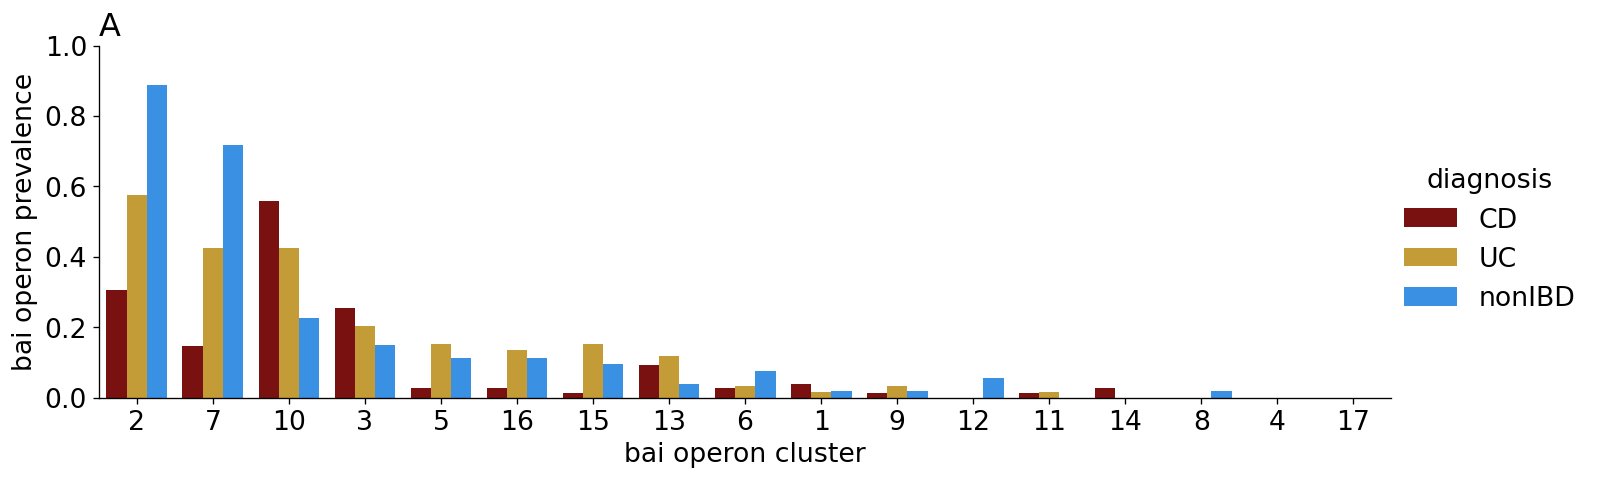

In [33]:
plt.rcParams.update({"font.size": 16})

plot_df = prev_grouped_df.rename(
    columns={
        "bai_cluster_name": "bai operon cluster",
        "cluster_prevalence": "bai operon prevalence",
    }
)


matplotlib.rcParams["figure.dpi"] = 120
g = (
    sns.catplot(
        data=plot_df,
        x="bai operon cluster",
        order=cluster_order,
        hue="diagnosis",
        hue_order=diag_order,
        # dodge=True,
        palette=pal2use,
        y="bai operon prevalence",
        height=4,
        aspect=3.0,
        kind="bar",
    )
    # .set_xticklabels(rotation=90)
    .set(ylim=(0, 1))
)

g.axes.flatten()[0].set_title("A", loc="left")

# plt.savefig("figures/Figure_2a.tiff", format="tiff", dpi=200, bbox_inches="tight")

### abundance

In [34]:
# add placeholder rows to capture all possible combinations

all_sample_list = Franzosa_runinfo_df.loc[
    Franzosa_runinfo_df["spots"] > 1e7, "Run"
].tolist()

bai_gene_list = ["BaiA", "BaiB", "BaiCD", "BaiE", "BaiF", "BaiG", "BaiH", "BaiI"]

placeholder_list = []

for cur_sample in all_sample_list:
    for cur_gene in bai_gene_list:
        new_df = pd.DataFrame(
            {
                "Run": cur_sample,
                "bai_cluster_name": "placeholder",
                "gene": bai_gene_list,
                "qseqid": 0,
            }
        )
        placeholder_list.append(new_df)

placeholder_df = pd.concat(placeholder_list)
print(placeholder_df.shape)
placeholder_df.head()

(11968, 4)


,Run,bai_cluster_name,gene,qseqid
0,SRR6468503,placeholder,BaiA,0
1,SRR6468503,placeholder,BaiB,0
2,SRR6468503,placeholder,BaiCD,0
3,SRR6468503,placeholder,BaiE,0
4,SRR6468503,placeholder,BaiF,0


In [35]:
gene_pivot_df = (
    pd.concat([tax_gene2_df, placeholder_df])
    .pivot_table(index=["Run", "gene"], columns="bai_cluster_name", values="qseqid")
    .fillna(0)
)
gene_pivot_df["gene_total"] = gene_pivot_df.apply(sum, axis="columns")
gene_pivot_df = gene_pivot_df.reset_index()
print(gene_pivot_df.shape)
gene_pivot_df.head()

(1658, 21)


bai_cluster_name,Run,gene,1,10,11,12,13,14,15,16,...,2,3,4,5,6,7,8,9,placeholder,gene_total
0,SRR6468499,BaiA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,16.0
1,SRR6468499,BaiB,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,17.0
2,SRR6468499,BaiCD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,35.0
3,SRR6468499,BaiE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,14.0
4,SRR6468499,BaiF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,70.0


In [36]:
melted_plot_df = gene_pivot_df.melt(
    id_vars=["Run", "gene", "gene_total"],
    var_name="bai_cluster_name",
    value_name="reads",
)
melted_plot_df = melted_plot_df.merge(Franzosa_df[["Run", "all_reads"]])
melted_plot_df["norm_cov"] = melted_plot_df["reads"] / melted_plot_df[
    "all_reads"
].apply(float)
melted_plot_df.loc[melted_plot_df["norm_cov"] == 0, "norm_cov"] = 1e-9
melted_plot_df["norm_cov_log10"] = melted_plot_df["norm_cov"].apply(math.log10)
melted_plot_df["read_prop"] = melted_plot_df["reads"] / melted_plot_df[
    "gene_total"
].apply(float)
melted_plot_df.loc[melted_plot_df["read_prop"].isna(), "read_prop"] = 0
print(melted_plot_df.shape)
melted_plot_df.head()

(26928, 9)


,Run,gene,gene_total,bai_cluster_name,reads,all_reads,norm_cov,norm_cov_log10,read_prop
0,SRR6468499,BaiA,16.0,1,0.0,11451636.0,1.000000e-09,-9.0,0.0
1,SRR6468499,BaiB,17.0,1,0.0,11451636.0,1.000000e-09,-9.0,0.0
2,SRR6468499,BaiCD,35.0,1,0.0,11451636.0,1.000000e-09,-9.0,0.0
3,SRR6468499,BaiE,14.0,1,0.0,11451636.0,1.000000e-09,-9.0,0.0
4,SRR6468499,BaiF,70.0,1,0.0,11451636.0,1.000000e-09,-9.0,0.0


In [37]:
mean_df = (
    melted_plot_df.groupby(["Run", "bai_cluster_name"])["norm_cov_log10"]
    .mean()
    .reset_index()
).rename(columns={"norm_cov_log10": "Bai_mean_cluster"})
mean_df["norm_cov"] = mean_df["Bai_mean_cluster"].apply(lambda x: 10**x)
print(mean_df.shape)
mean_df.head()

(3366, 4)


,Run,bai_cluster_name,Bai_mean_cluster,norm_cov
0,SRR6468499,1,-9.000000,1.000000e-09
1,SRR6468499,10,-8.719730,1.906647e-09
2,SRR6468499,11,-9.000000,1.000000e-09
3,SRR6468499,12,-8.757358,1.748403e-09
4,SRR6468499,13,-9.000000,1.000000e-09


In [38]:
merged_mean_df = mean_df.merge(
    Franzosa_df[["Sample", "geo_loc", "Bai_mean", "diagnosis", "DCA:CA_log10"]],
    left_on="Run",
    right_on="Sample",
)
print(merged_mean_df.shape)
merged_mean_df.head()

(3366, 9)


,Run,bai_cluster_name,Bai_mean_cluster,norm_cov,Sample,geo_loc,Bai_mean,diagnosis,DCA:CA_log10
0,SRR6468499,1,-9.000000,1.000000e-09,SRR6468499,Netherlands,-5.878435,UC,1.62403
1,SRR6468499,10,-8.719730,1.906647e-09,SRR6468499,Netherlands,-5.878435,UC,1.62403
2,SRR6468499,11,-9.000000,1.000000e-09,SRR6468499,Netherlands,-5.878435,UC,1.62403
3,SRR6468499,12,-8.757358,1.748403e-09,SRR6468499,Netherlands,-5.878435,UC,1.62403
4,SRR6468499,13,-9.000000,1.000000e-09,SRR6468499,Netherlands,-5.878435,UC,1.62403


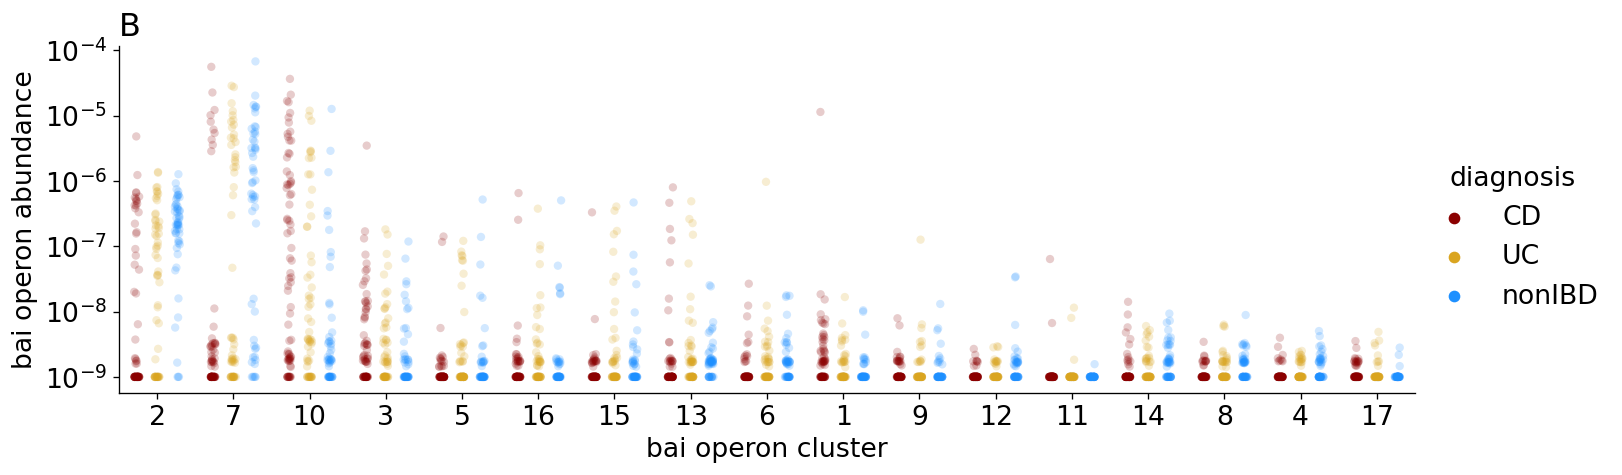

In [39]:
plt.rcParams.update({"font.size": 16})

plot_df = merged_mean_df.rename(
    columns={
        "bai_cluster_name": "bai operon cluster",
        "Bai_mean_cluster": "bai operon abundance",
    }
)

matplotlib.rcParams["figure.dpi"] = 120
g = sns.catplot(
    data=plot_df,
    x="bai operon cluster",
    order=cluster_order,
    hue="diagnosis",
    hue_order=diag_order,
    dodge=True,
    palette=pal2use,
    y="bai operon abundance",
    height=4,
    aspect=3.0,
    alpha=0.2,
)  # .set_xticklabels(rotation=90)

g.axes.flatten()[0].set_title("B", loc="left")

reformatted_x_labels = [
    r"$\mathregular{10^{-9}}$",
    r"$\mathregular{10^{-8}}$",
    r"$\mathregular{10^{-7}}$",
    r"$\mathregular{10^{-6}}$",
    r"$\mathregular{10^{-5}}$",
    r"$\mathregular{10^{-4}}$",
]

g.axes.flatten()[0].set_yticks([-9, -8, -7, -6, -5, -4], reformatted_x_labels)

# plt.savefig("figures/Figure_2b.tiff", format="tiff", dpi=200, bbox_inches="tight")
plt.show()

## Correlations between taxa

In [40]:
merged_mean_renamed_df = merged_mean_df.copy()
merged_mean_renamed_df["bai_cluster_name"] = (
    "bai_cluster_" + merged_mean_renamed_df["bai_cluster_name"]
)
wide_cluster_df = merged_mean_renamed_df.pivot_table(
    values="Bai_mean_cluster",
    index=["Run", "diagnosis", "Bai_mean", "DCA:CA_log10"],
    columns="bai_cluster_name",
).reset_index()
wide_cluster_df["SBA"] = "high_SBA"
wide_cluster_df.loc[wide_cluster_df["DCA:CA_log10"] < 0, "SBA"] = "low_SBA"
print(wide_cluster_df.shape)
wide_cluster_df.head()

(187, 23)


bai_cluster_name,Run,diagnosis,Bai_mean,DCA:CA_log10,bai_cluster_1,bai_cluster_10,bai_cluster_11,bai_cluster_12,bai_cluster_13,bai_cluster_14,...,bai_cluster_2,bai_cluster_3,bai_cluster_4,bai_cluster_5,bai_cluster_6,bai_cluster_7,bai_cluster_8,bai_cluster_9,bai_cluster_placeholder,SBA
0,SRR6468499,UC,-5.878435,1.624030,-9.00000,-8.719730,-9.0,-8.757358,-9.000000,-8.757358,...,-6.942946,-9.000000,-9.000000,-9.000000,-9.000000,-5.872095,-8.757358,-9.00000,-9.0,high_SBA
1,SRR6468500,UC,-5.443982,2.244147,-9.00000,-9.000000,-9.0,-8.757992,-8.720363,-8.720363,...,-6.230150,-9.000000,-8.720363,-9.000000,-8.139077,-5.348518,-8.682734,-9.00000,-9.0,high_SBA
2,SRR6468502,CD,-5.240304,0.950540,-8.38919,-4.959722,-9.0,-9.000000,-8.771498,-9.000000,...,-9.000000,-7.375323,-9.000000,-8.733869,-9.000000,-9.000000,-9.000000,-8.69624,-9.0,high_SBA
3,SRR6468503,nonIBD,-5.497004,2.294533,-9.00000,-8.389832,-9.0,-9.000000,-8.546741,-8.509112,...,-8.244854,-8.260471,-9.000000,-9.000000,-8.773370,-5.275707,-8.735742,-9.00000,-9.0,high_SBA
4,SRR6468505,CD,-7.647852,0.212759,-9.00000,-8.710298,-9.0,-9.000000,-9.000000,-9.000000,...,-7.722588,-9.000000,-9.000000,-9.000000,-8.672670,-8.769939,-9.000000,-9.00000,-9.0,high_SBA


In [41]:
reformatted_locs = [-9, -8, -7, -6, -5, -4]
reformatted_labels = [
    r"$\mathregular{10^{-9}}$",
    r"$\mathregular{10^{-8}}$",
    r"$\mathregular{10^{-7}}$",
    r"$\mathregular{10^{-6}}$",
    r"$\mathregular{10^{-5}}$",
    r"$\mathregular{10^{-4}}$",
]

In [42]:
matplotlib.rcParams["figure.dpi"] = 120
plt.rcParams.update({"font.size": 16})

plot_df = wide_cluster_df.rename(
    columns={
        "bai_cluster_2": "cluster 2 bai operon abundance",
        "bai_cluster_7": "cluster 7 bai operon abundance",
        "bai_cluster_10": "cluster 10 bai operon abundance",
    }
)

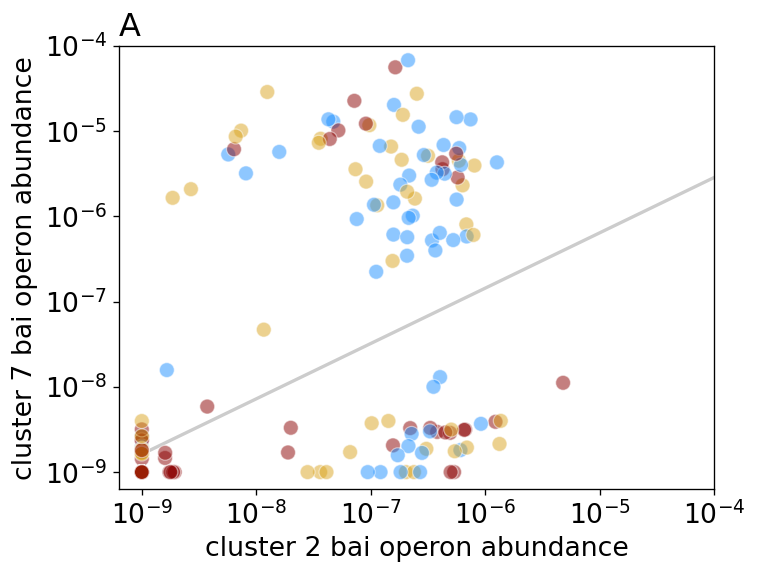

In [43]:
x_cluster = "cluster 2 bai operon abundance"
y_cluster = "cluster 7 bai operon abundance"

slope, intercept, low_slope, high_slope = theilslopes(
    plot_df[y_cluster], plot_df[[x_cluster]], method="joint"
)

g = sns.scatterplot(
    data=plot_df,
    x=x_cluster,
    y=y_cluster,
    hue="diagnosis",
    palette=pal2use,
    s=80,
    alpha=0.5,
    legend=False,
)
g.set_xlim(-9.2, -4)
g.set_ylim(-9.2, -4)

g.plot(
    [-9, 0],
    [intercept + (-9 * slope), intercept],
    color="black",
    alpha=0.2,
    zorder=0,
    linewidth=2,
)

g.axes.set_title("A", loc="left")

g.set_xticks(reformatted_locs, reformatted_labels)
g.set_yticks(reformatted_locs, reformatted_labels)

# plt.savefig("figures/Figure_3a.tiff", format="tiff", dpi=200, bbox_inches="tight")
plt.show()

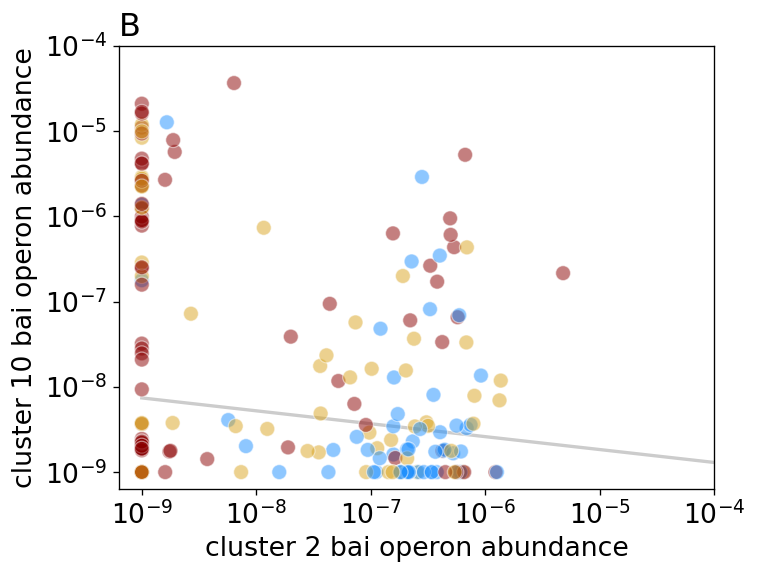

In [44]:
plt.close()

x_cluster = "cluster 2 bai operon abundance"
y_cluster = "cluster 10 bai operon abundance"

slope, intercept, low_slope, high_slope = theilslopes(
    plot_df[y_cluster], plot_df[[x_cluster]], method="joint"
)

g = sns.scatterplot(
    data=plot_df,
    x=x_cluster,
    y=y_cluster,
    hue="diagnosis",
    palette=pal2use,
    s=80,
    alpha=0.5,
    legend=False,
)
g.set_xlim(-9.2, -4)
g.set_ylim(-9.2, -4)

g.plot(
    [-9, 0],
    [intercept + (-9 * slope), intercept],
    color="black",
    alpha=0.2,
    zorder=0,
    linewidth=2,
)

g.axes.set_title("B", loc="left")

g.set_xticks(reformatted_locs, reformatted_labels)
g.set_yticks(reformatted_locs, reformatted_labels)

# plt.savefig("figures/Figure_3b.tiff", format="tiff", dpi=200, bbox_inches="tight")
plt.show()

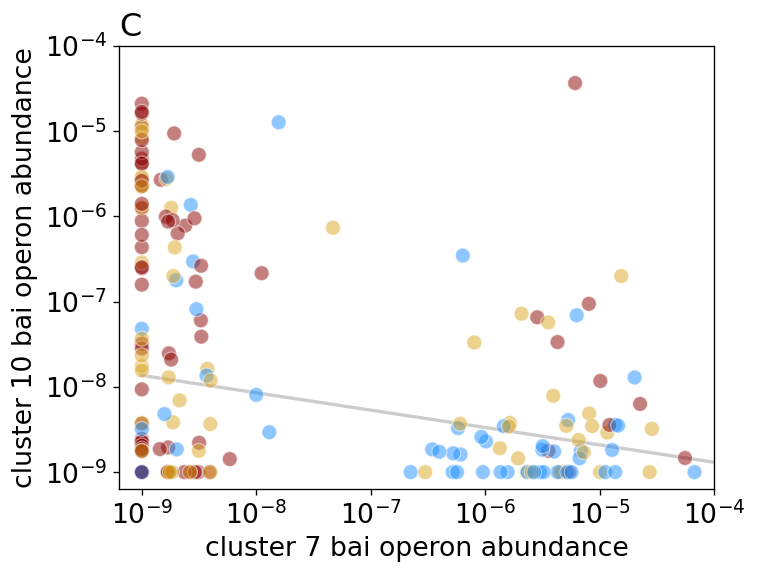

In [45]:
plt.close()

x_cluster = "cluster 7 bai operon abundance"
y_cluster = "cluster 10 bai operon abundance"

slope, intercept, low_slope, high_slope = theilslopes(
    plot_df[y_cluster], plot_df[[x_cluster]], method="joint"
)

g = sns.scatterplot(
    data=plot_df,
    x=x_cluster,
    y=y_cluster,
    hue="diagnosis",
    palette=pal2use,
    s=80,
    alpha=0.5,
    legend=False,
)
g.set_xlim(-9.2, -4)
g.set_ylim(-9.2, -4)

g.plot(
    [-9, 0],
    [intercept + (-9 * slope), intercept],
    color="black",
    alpha=0.2,
    zorder=0,
    linewidth=2,
)
g.axes.set_title("C", loc="left")

g.set_xticks(reformatted_locs, reformatted_labels)
g.set_yticks(reformatted_locs, reformatted_labels)

# plt.savefig("figures/Figure_3c.tiff", format="tiff", dpi=200, bbox_inches="tight")
plt.show()

In [46]:
stats.spearmanr(
    wide_cluster_df["bai_cluster_2"].tolist(),
    wide_cluster_df["bai_cluster_7"].tolist(),
    alternative="two-sided",
)

SignificanceResult(statistic=0.5849148654914107, pvalue=1.4947048784319746e-18)

In [47]:
stats.spearmanr(
    wide_cluster_df["bai_cluster_2"].tolist(),
    wide_cluster_df["bai_cluster_10"].tolist(),
    alternative="two-sided",
)

SignificanceResult(statistic=-0.26226352408981507, pvalue=0.00028780998838243865)

In [48]:
stats.spearmanr(
    wide_cluster_df["bai_cluster_7"].tolist(),
    wide_cluster_df["bai_cluster_10"].tolist(),
    alternative="two-sided",
)

SignificanceResult(statistic=-0.3468276200306438, pvalue=1.1574343813511392e-06)

# FMT results (Vaughn 2016)

In [49]:
Vaughn_bai_df = pd.read_csv("paper_data/Vaughn_2016_bai_genes.csv")[
    ["Run", "host_subject_ID", "time_point", "responder", "Bai_mean"]
]
print(Vaughn_bai_df.shape)
Vaughn_bai_df.head()

(53, 5)


,Run,host_subject_ID,time_point,responder,Bai_mean
0,SRR3582131,R1004,pre-FMT,True,-5.555814
1,SRR3582132,R1002,8 weeks after FMT,False,-9.000000
2,SRR3582133,R1002,pre-FMT,False,-9.000000
3,SRR3582134,D9001,Donor,False,-6.920158
4,SRR3582135,R1001,pre-FMT,True,-7.274166


In [50]:
Vaughn_donor_df = pd.read_csv("paper_data/Vaughn_Moss_CD_FMT_outcomes.csv")
Vaughn_donor_df["donor"] = Vaughn_donor_df["Donor ID"].apply(
    lambda x: re.sub("[ -].*", "", x)
)
donor_dict = dict(zip(Vaughn_donor_df["Recipient ID"], Vaughn_donor_df["donor"]))
print(Vaughn_donor_df.shape)
Vaughn_donor_df.head()

(22, 3)


,Recipient ID,Donor ID,donor
0,R1001,D9001 - A,D9001
1,R1002,D9002 - C,D9002
2,R1003,D9001 - B,D9001
3,R1004,D9002 - A,D9002
4,R1005,D9002 - B,D9002


In [51]:
Vaughn_sra_df = pd.read_csv("paper_data/Vaughn_2016_SraRunInfo.csv")
spots_dict = dict(zip(Vaughn_sra_df["Run"], Vaughn_sra_df["spots"]))
print(Vaughn_sra_df.shape)

(53, 47)


In [52]:
Vaughn_bai_df["Donor"] = Vaughn_bai_df["host_subject_ID"].map(donor_dict.get)
Vaughn_bai_df["spots"] = Vaughn_bai_df["Run"].map(spots_dict.get)
Vaughn_bai_df.loc[Vaughn_bai_df["time_point"] == "Donor", "responder"] = "donor"
Vaughn_bai_df.loc[Vaughn_bai_df["responder"] == False, "responder"] = "no"
Vaughn_bai_df.loc[Vaughn_bai_df["responder"] == True, "responder"] = "yes"
print(Vaughn_bai_df.shape)
Vaughn_bai_df.head()

(53, 7)


,Run,host_subject_ID,time_point,responder,Bai_mean,Donor,spots
0,SRR3582131,R1004,pre-FMT,yes,-5.555814,D9002,26839268
1,SRR3582132,R1002,8 weeks after FMT,no,-9.000000,D9002,11043362
2,SRR3582133,R1002,pre-FMT,no,-9.000000,D9002,12407301
3,SRR3582134,D9001,Donor,donor,-6.920158,None,23303772
4,SRR3582135,R1001,pre-FMT,yes,-7.274166,D9001,20040773


In [53]:
Counter(Vaughn_bai_df["responder"])

Counter({'yes': 28, 'no': 21, 'donor': 4})

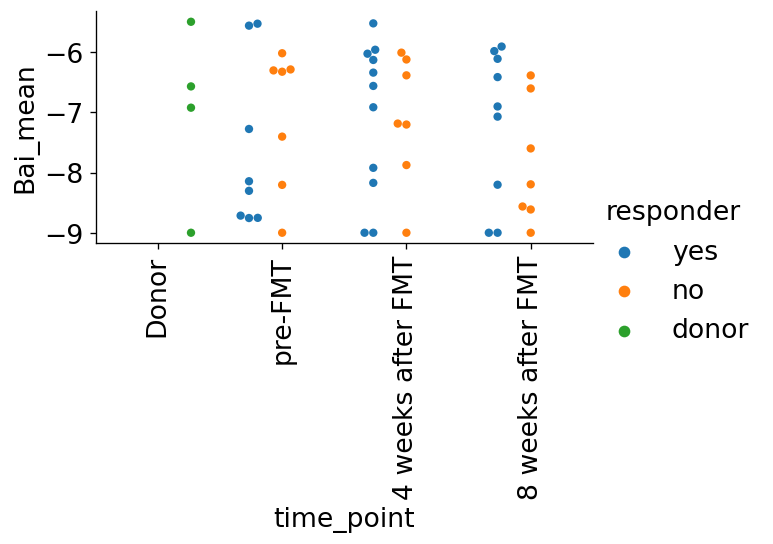

In [54]:
time_order = ["Donor", "pre-FMT", "4 weeks after FMT", "8 weeks after FMT"]

matplotlib.rcParams["figure.dpi"] = 120
g = sns.catplot(
    data=Vaughn_bai_df,
    x="time_point",
    y="Bai_mean",
    hue="responder",
    hue_order=["yes", "no", "donor"],
    dodge=True,
    kind="swarm",
    height=3,
    aspect=1.8,
    order=time_order,
).set_xticklabels(rotation=90)

Text(0.0, 1.0, 'A')

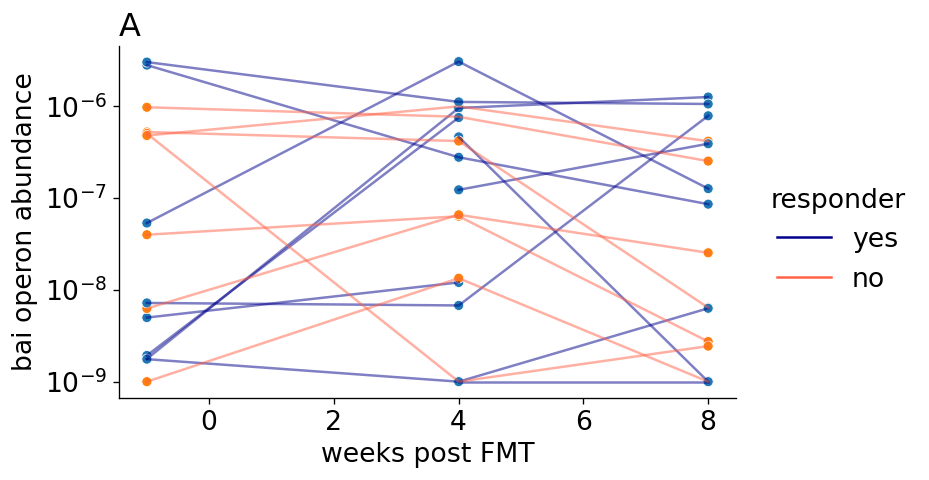

In [55]:
plot_df = Vaughn_bai_df.copy()
time_dict = {"pre-FMT": -1, "4 weeks after FMT": 4, "8 weeks after FMT": 8, "Donor": 0}
plot_df["weeks post FMT"] = plot_df["time_point"].apply(time_dict.get)
plot_df = plot_df[plot_df["time_point"] != "Donor"].copy()
plot_df.head()

plot_df = plot_df.rename(columns={"Bai_mean": "bai operon abundance"})

matplotlib.rcParams["figure.dpi"] = 120
g = sns.relplot(
    data=plot_df,
    x="weeks post FMT",
    y="bai operon abundance",
    units="host_subject_ID",
    hue="responder",
    hue_order=["yes", "no"],
    palette={"yes": "darkblue", "no": "tomato"},
    alpha=0.5,
    kind="line",
    height=4,
    aspect=1.6,
    estimator=None,
    color="black",
)

g.map(sns.scatterplot, "weeks post FMT", "bai operon abundance", "responder")

reformatted_locs = [-9, -8, -7, -6]
reformatted_labels = [
    r"$\mathregular{10^{-9}}$",
    r"$\mathregular{10^{-8}}$",
    r"$\mathregular{10^{-7}}$",
    r"$\mathregular{10^{-6}}$",
]

g.axes.flatten()[0].set_yticks(reformatted_locs, reformatted_labels)

g.axes.flatten()[0].set_title("A", loc="left")

# plt.savefig("figures/Figure_5a.tiff", format="tiff", dpi=200, bbox_inches="tight")

In [56]:
Vaughn_bai_df.head()

,Run,host_subject_ID,time_point,responder,Bai_mean,Donor,spots
0,SRR3582131,R1004,pre-FMT,yes,-5.555814,D9002,26839268
1,SRR3582132,R1002,8 weeks after FMT,no,-9.000000,D9002,11043362
2,SRR3582133,R1002,pre-FMT,no,-9.000000,D9002,12407301
3,SRR3582134,D9001,Donor,donor,-6.920158,None,23303772
4,SRR3582135,R1001,pre-FMT,yes,-7.274166,D9001,20040773


In [57]:
delta_df = Vaughn_bai_df.pivot_table(
    index=["host_subject_ID", "responder", "Donor"],
    values="Bai_mean",
    columns="time_point",
).reset_index()
delta_df["post_FMT"] = delta_df[["4 weeks after FMT", "8 weeks after FMT"]].mean(axis=1)
delta_df["delta_bai"] = delta_df["post_FMT"] - delta_df["pre-FMT"]
delta_df["delta_bai2"] = delta_df["8 weeks after FMT"] - delta_df["pre-FMT"]
delta_df

time_point,host_subject_ID,responder,Donor,4 weeks after FMT,8 weeks after FMT,pre-FMT,post_FMT,delta_bai,delta_bai2
0,R1001,yes,D9001,-5.517930,-6.899912,-7.274166,-6.208921,1.065245,0.374254
1,R1002,no,D9002,-7.874376,-9.000000,-9.000000,-8.437188,0.562812,0.000000
2,R1003,yes,D9001,-9.000000,-9.000000,NaN,-9.000000,NaN,NaN
3,R1004,yes,D9002,-6.558520,-7.068900,-5.555814,-6.813710,-1.257896,-1.513086
4,R1005,no,D9002,-6.004876,-6.383762,-6.322088,-6.194319,0.127769,-0.061674
5,R1006,yes,D9002,-6.022263,-5.903406,-8.752353,-5.962834,2.789519,2.848948
6,R1007,no,D9001,-6.118420,-6.600300,-6.014753,-6.359360,-0.344608,-0.585548
7,R1008,yes,D9001,-6.336816,-9.000000,NaN,-7.668408,NaN,NaN
8,R1009,yes,D9001,-6.126330,NaN,-8.715153,-6.126330,2.588823,NaN
9,R1011,no,D9002,-7.200436,-8.563521,-7.401386,-7.881979,-0.480593,-1.162135


Text(0.0, 1.0, 'B')

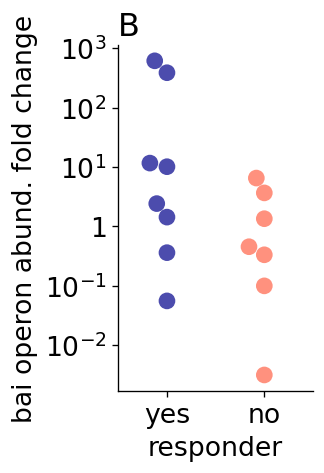

In [58]:
matplotlib.rcParams["figure.dpi"] = 120

plot_df = delta_df.rename(columns={"delta_bai": "bai operon abund. fold change"})

g = sns.catplot(
    data=plot_df,
    x="responder",
    order=["yes", "no"],
    y="bai operon abund. fold change",
    kind="swarm",
    hue="responder",
    palette={"yes": "darkblue", "no": "tomato"},
    height=4,
    aspect=0.7,
    alpha=0.7,
    s=100,
)

reformatted_locs = [-2, -1, 0, 1, 2, 3]
reformatted_labels = [
    r"$\mathregular{10^{-2}}$",
    r"$\mathregular{10^{-1}}$",
    r"$\mathregular{1}}$",
    r"$\mathregular{10^{1}}$",
    r"$\mathregular{10^{2}}$",
    r"$\mathregular{10^{3}}$",
]

g.axes.flatten()[0].set_yticks(reformatted_locs, reformatted_labels)

g.axes.flatten()[0].set_title("B", loc="left")

# plt.savefig("figures/Figure_5b.tiff", format="tiff", dpi=200, bbox_inches="tight")

In [59]:
stats.mannwhitneyu(
    delta_df.loc[delta_df["responder"] == "yes", "delta_bai"].dropna().tolist(),
    delta_df.loc[delta_df["responder"] == "no", "delta_bai"].dropna().tolist(),
    alternative="two-sided",
    method="exact",
)

MannwhitneyuResult(statistic=42.0, pvalue=0.1205905205905206)

In [60]:
print(Counter(delta_df["responder"]))

Counter({'yes': 11, 'no': 7})


In [61]:
42 / (11 * 7)

0.5454545454545454

### taxa

In [62]:
Vaughn_bai_taxa_df = pd.read_csv("paper_data/Vaughn2016_bai_taxa_results.csv")
Vaughn_bai_taxa_df["Donor"] = Vaughn_bai_taxa_df["host_subject_ID"].map(donor_dict.get)
Vaughn_bai_taxa_df.loc[Vaughn_bai_taxa_df["responder"] == False, "responder"] = "no"
Vaughn_bai_taxa_df.loc[Vaughn_bai_taxa_df["responder"] == True, "responder"] = "yes"
print(Vaughn_bai_taxa_df.shape)
Vaughn_bai_taxa_df.head()

(848, 9)


,Run,bai_cluster_name,norm_cov_log10,norm_cov,spots,host_subject_ID,Donor,time_point,responder
0,SRR3582131,bai_cluster_1,-9.000000,1.000000e-09,26839268,R1004,D9002,pre-FMT,yes
1,SRR3582131,bai_cluster_10,-9.000000,1.000000e-09,26839268,R1004,D9002,pre-FMT,yes
2,SRR3582131,bai_cluster_12,-9.000000,1.000000e-09,26839268,R1004,D9002,pre-FMT,yes
3,SRR3582131,bai_cluster_13,-8.803596,1.571823e-09,26839268,R1004,D9002,pre-FMT,yes
4,SRR3582131,bai_cluster_14,-9.000000,1.000000e-09,26839268,R1004,D9002,pre-FMT,yes


In [63]:
Vaughn_bai_taxa_df.groupby(["Donor", "responder"])["host_subject_ID"].nunique()

Donor  responder
D9001  no           1
       yes          4
D9002  no           3
       yes          2
D9004  no           2
       yes          2
D9005  no           1
       yes          3
Name: host_subject_ID, dtype: int64

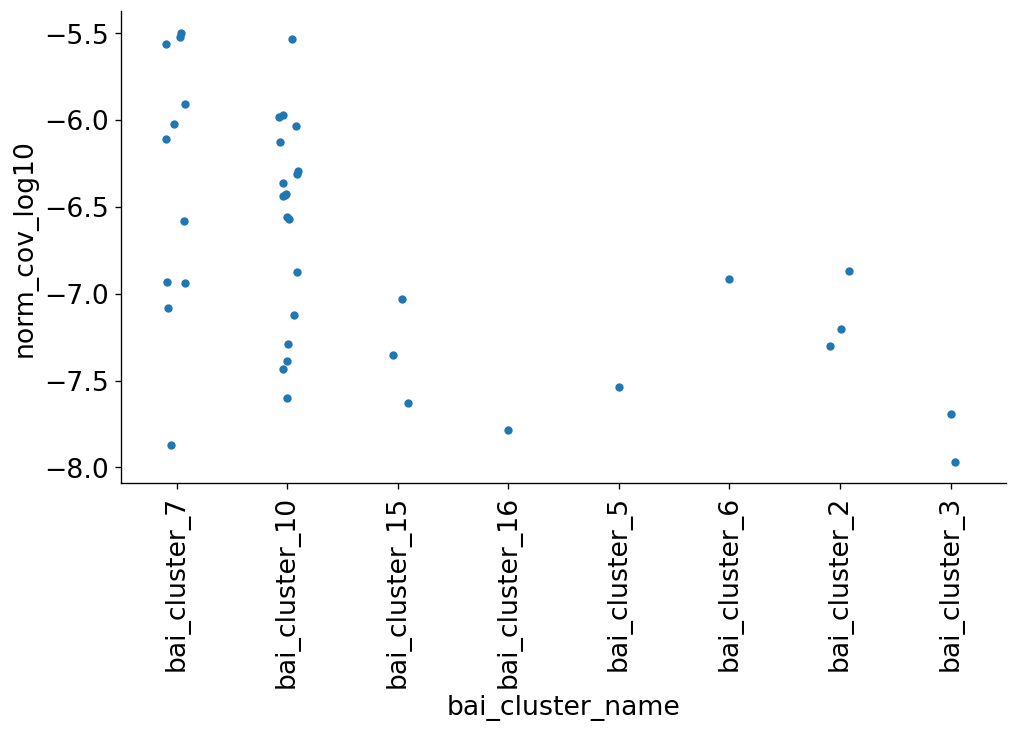

In [64]:
time_order = ["Donor", "pre-FMT", "4 weeks after FMT", "8 weeks after FMT"]

matplotlib.rcParams["figure.dpi"] = 120
g = sns.catplot(
    data=Vaughn_bai_taxa_df[Vaughn_bai_taxa_df["norm_cov_log10"] > -8],
    x="bai_cluster_name",
    # row="time_point",
    y="norm_cov_log10",
    # hue="responder",
    # hue_order=["Yes", "No", "Donor"],
    # dodge=True,
    kind="strip",
    # height=3,
    aspect=1.8,
    col_order=time_order,
).set_xticklabels(rotation=90)

In [65]:
top_clusters = (
    Vaughn_bai_taxa_df.groupby(["bai_cluster_name"])["norm_cov_log10"]
    .mean()
    .reset_index()
    .sort_values("norm_cov_log10", ascending=False)
    .head(3)
)["bai_cluster_name"].tolist()
top_clusters

['bai_cluster_10', 'bai_cluster_7', 'bai_cluster_2']

In [66]:
donor_order = Vaughn_bai_taxa_df["Donor"].dropna().sort_values().unique().tolist()
donor_order

['D9001', 'D9002', 'D9004', 'D9005']

In [67]:
orig_10_palette = sns.color_palette(n_colors=10)
orig_10_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [68]:
cluster_order = ["bai_cluster_2", "bai_cluster_7", "bai_cluster_10"]
cluster_palette = dict(
    zip(cluster_order, [orig_10_palette[1], orig_10_palette[5], orig_10_palette[6]])
)

In [69]:
plot_df = Vaughn_bai_taxa_df[
    Vaughn_bai_taxa_df["bai_cluster_name"].isin(top_clusters)
].copy()
plot_df = plot_df[plot_df["time_point"] == "Donor"].copy()
plot_df

,Run,bai_cluster_name,norm_cov_log10,norm_cov,spots,host_subject_ID,Donor,time_point,responder
49,SRR3582134,bai_cluster_10,-9.000000,1.000000e-09,23303772,D9001,None,Donor,no
55,SRR3582134,bai_cluster_2,-9.000000,1.000000e-09,23303772,D9001,None,Donor,no
60,SRR3582134,bai_cluster_7,-6.932664,1.167712e-07,23303772,D9001,None,Donor,no
177,SRR3582142,bai_cluster_10,-9.000000,1.000000e-09,21541016,D9004,None,Donor,no
183,SRR3582142,bai_cluster_2,-9.000000,1.000000e-09,21541016,D9004,None,Donor,no
188,SRR3582142,bai_cluster_7,-9.000000,1.000000e-09,21541016,D9004,None,Donor,no
433,SRR3582158,bai_cluster_10,-8.504972,3.126278e-09,29609747,D9005,None,Donor,no
439,SRR3582158,bai_cluster_2,-6.869624,1.350132e-07,29609747,D9005,None,Donor,no
444,SRR3582158,bai_cluster_7,-8.558219,2.765550e-09,29609747,D9005,None,Donor,no
769,SRR3582179,bai_cluster_10,-9.000000,1.000000e-09,47495435,D9002,None,Donor,no


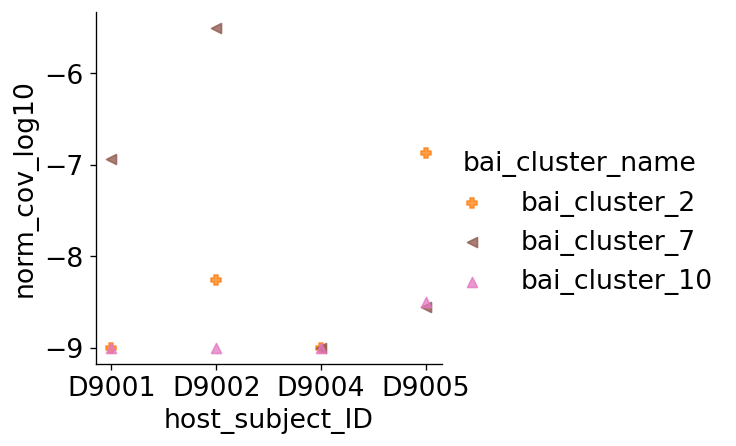

In [70]:
matplotlib.rcParams["figure.dpi"] = 120
g = sns.FacetGrid(
    data=plot_df.sort_values("host_subject_ID"),
    hue="bai_cluster_name",
    hue_order=cluster_order,
    palette=cluster_palette,
    height=4,
    aspect=1.1,
    hue_kws=dict(marker=["P", "<", "^"]),
)
g = g.map(plt.scatter, "host_subject_ID", "norm_cov_log10", alpha=0.75)
g.add_legend()

Text(0.0, 1.0, 'C')

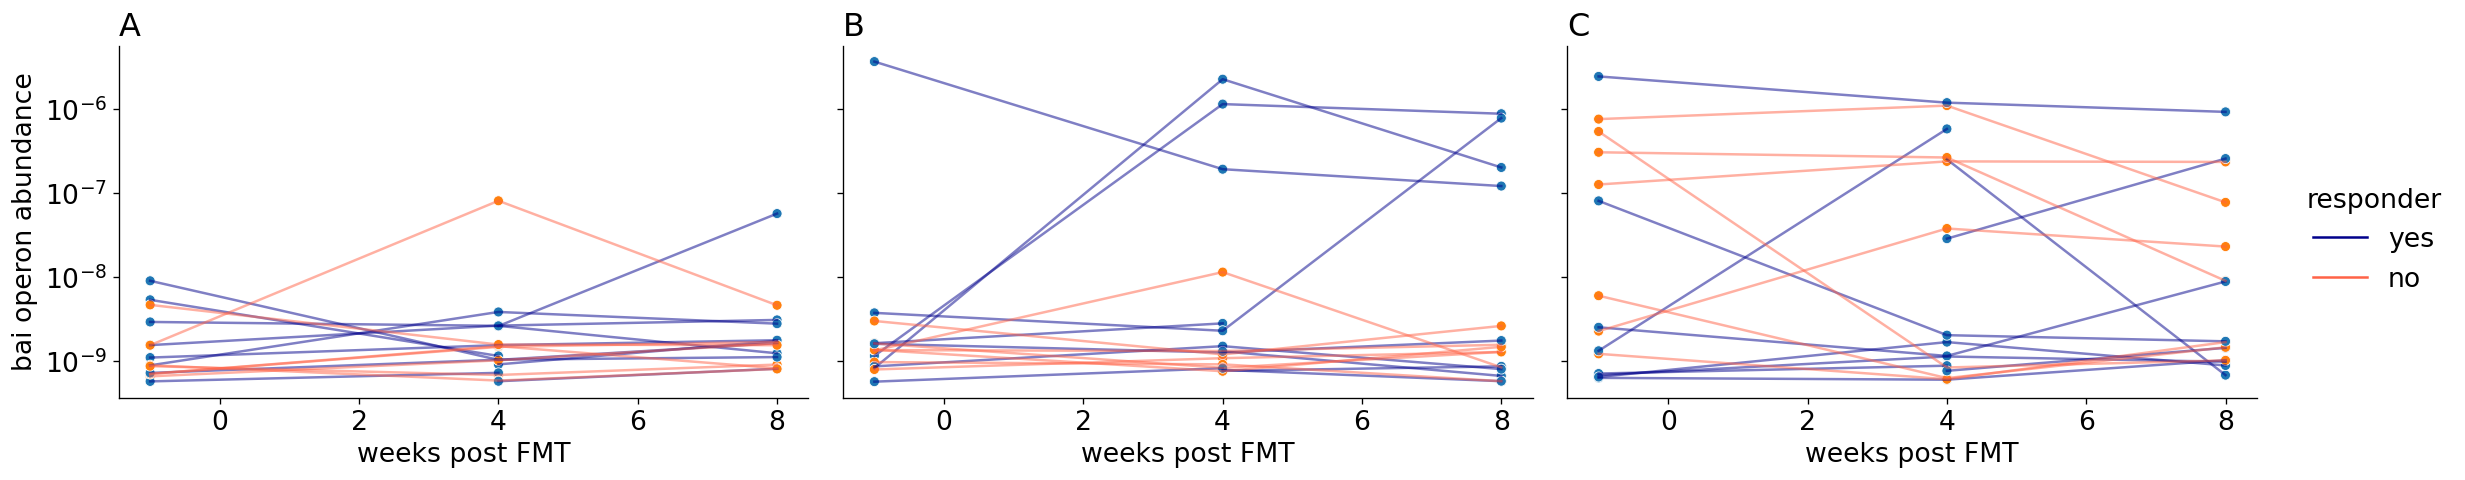

In [71]:
plt.rcParams.update({"font.size": 16})

plot_df = Vaughn_bai_taxa_df[Vaughn_bai_taxa_df["bai_cluster_name"].isin(top_clusters)]
plot_df = plot_df[plot_df["time_point"] != "Donor"]

time_dict = {"pre-FMT": -1, "4 weeks after FMT": 4, "8 weeks after FMT": 8, "Donor": 0}

plot_df["weeks post FMT"] = plot_df["time_point"].apply(time_dict.get)

plot_df["bai operon abundance"] = plot_df["norm_cov_log10"] + np.random.uniform(
    low=-0.25, high=0.25, size=plot_df.shape[0]
)

plot_df = plot_df.rename(columns={"Bai_mean": "bai operon abundance"})

matplotlib.rcParams["figure.dpi"] = 120
g = sns.relplot(
    data=plot_df,
    x="weeks post FMT",
    y="bai operon abundance",
    units="host_subject_ID",
    col="bai_cluster_name",
    col_wrap=3,
    col_order=cluster_order,
    hue="responder",
    hue_order=["yes", "no"],
    palette={"yes": "darkblue", "no": "tomato"},
    alpha=0.5,
    kind="line",
    height=4,
    aspect=1.6,
    estimator=None,
    color="black",
)

g.set_titles("")

g.map(sns.scatterplot, "weeks post FMT", "bai operon abundance", "responder")

reformatted_locs = [-9, -8, -7, -6]
reformatted_labels = [
    r"$\mathregular{10^{-9}}$",
    r"$\mathregular{10^{-8}}$",
    r"$\mathregular{10^{-7}}$",
    r"$\mathregular{10^{-6}}$",
]

g.axes.flatten()[0].set_yticks(reformatted_locs, reformatted_labels)

axes = g.axes.flatten()
axes[0].set_title("A", loc="left")
axes[1].set_title("B", loc="left")
axes[2].set_title("C", loc="left")

# plt.savefig("figures/Figure_6.tiff", format="tiff", dpi=200, bbox_inches="tight")

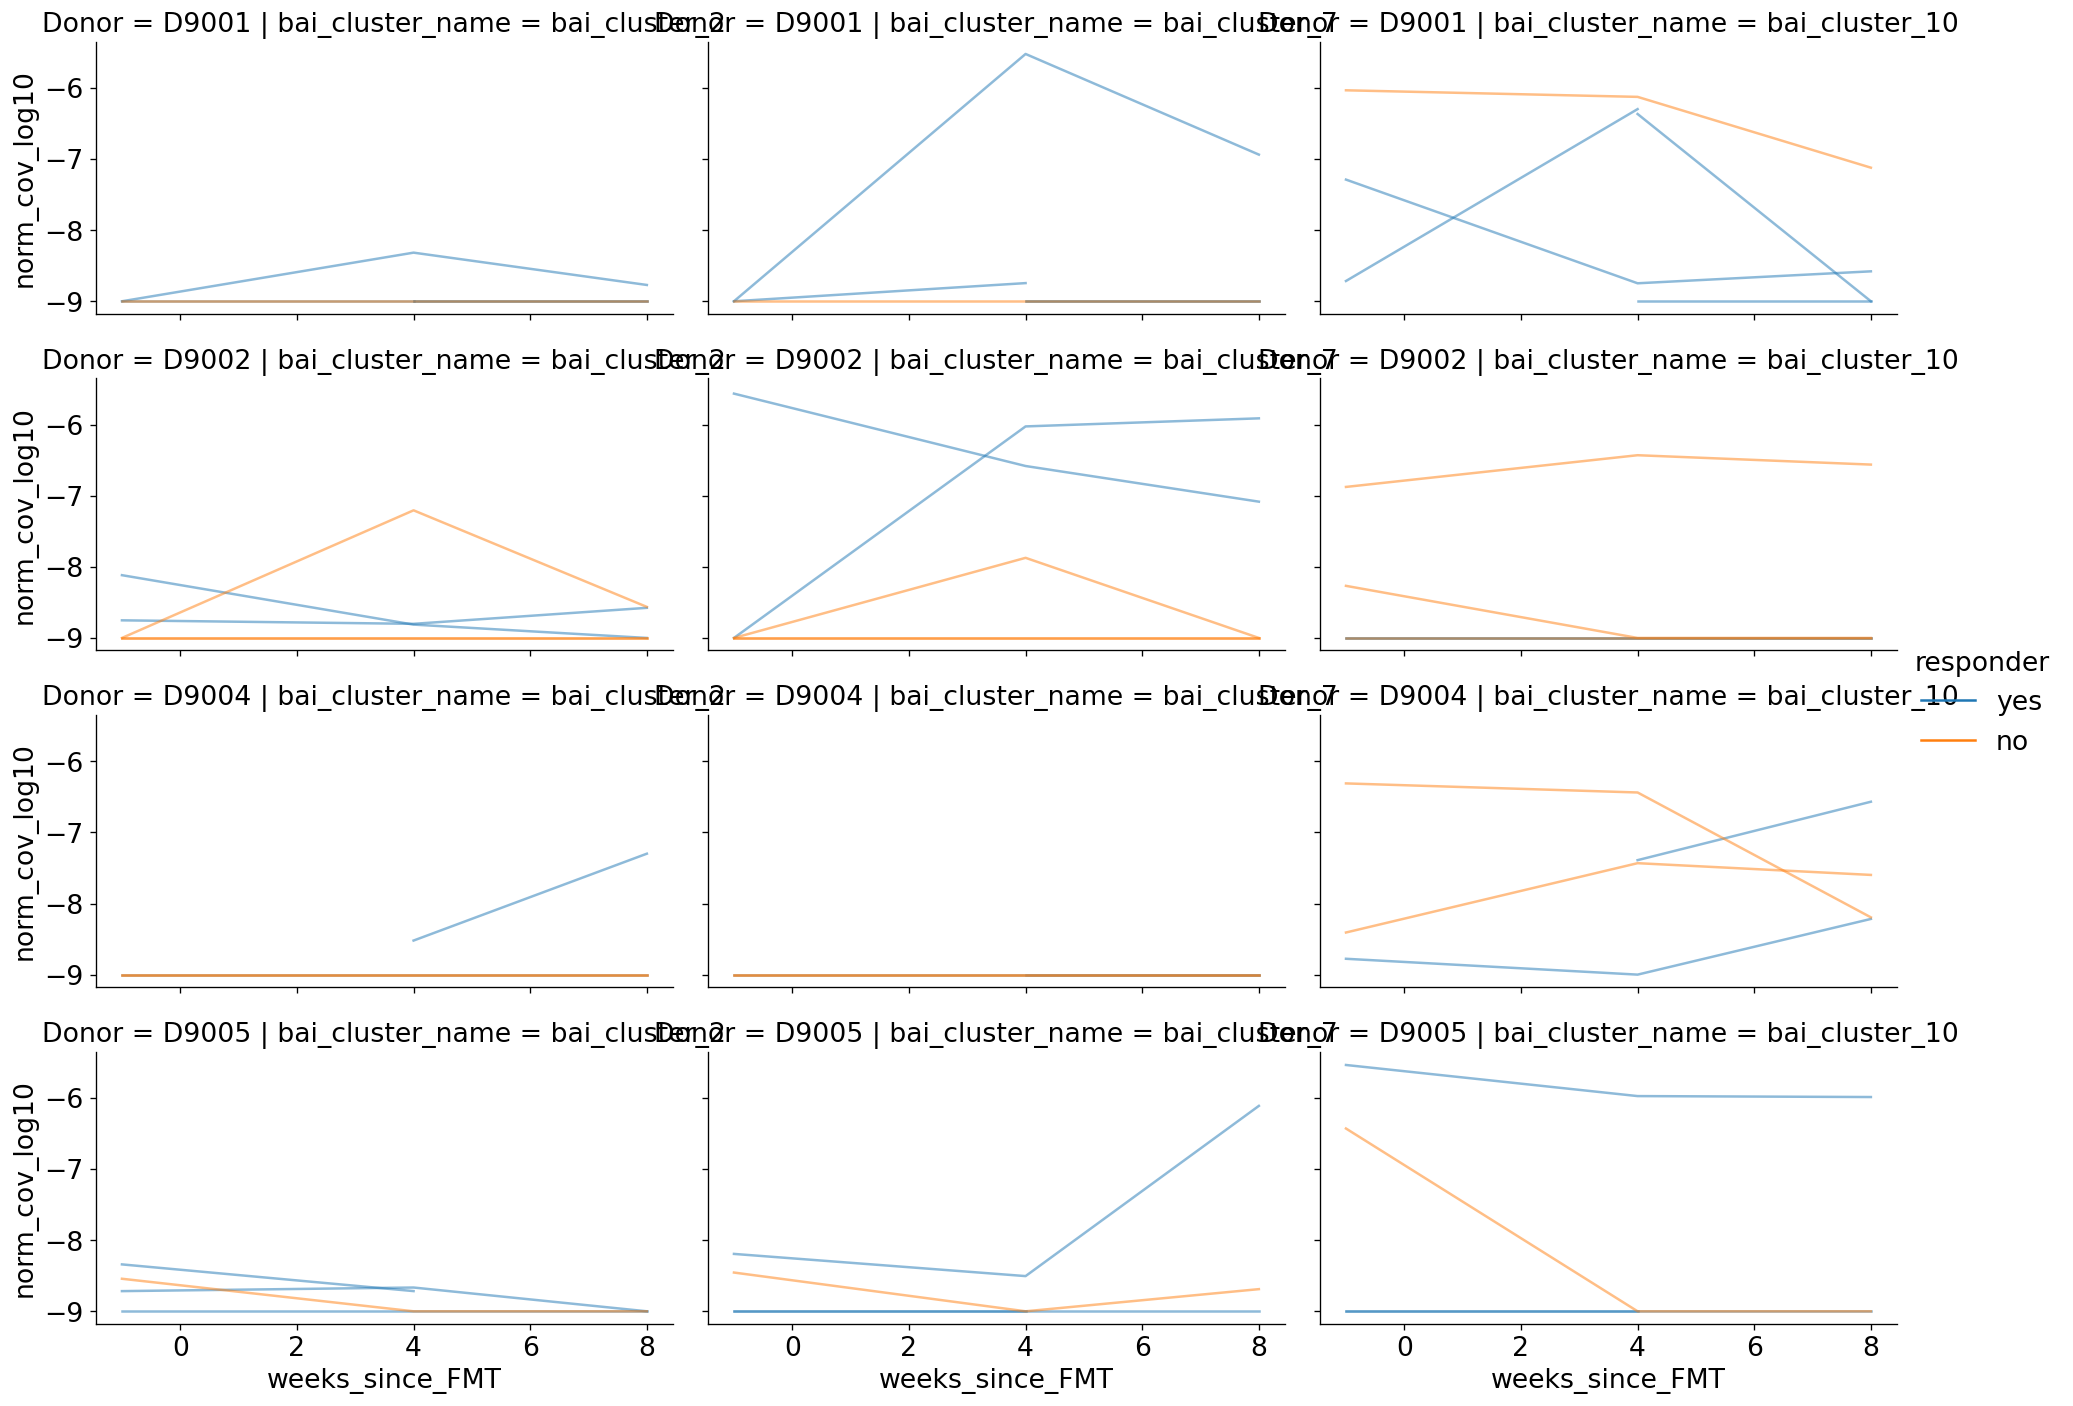

In [72]:
plot_df = Vaughn_bai_taxa_df[Vaughn_bai_taxa_df["bai_cluster_name"].isin(top_clusters)]
plot_df = plot_df[plot_df["time_point"] != "Donor"]

time_dict = {"pre-FMT": -1, "4 weeks after FMT": 4, "8 weeks after FMT": 8, "Donor": 0}

plot_df["weeks_since_FMT"] = plot_df["time_point"].apply(time_dict.get)

matplotlib.rcParams["figure.dpi"] = 120
g = sns.relplot(
    data=plot_df,
    x="weeks_since_FMT",
    y="norm_cov_log10",
    units="host_subject_ID",
    col="bai_cluster_name",
    col_order=cluster_order,
    row="Donor",
    row_order=donor_order,
    hue="responder",
    hue_order=["yes", "no"],
    alpha=0.5,
    kind="line",
    height=3,
    aspect=1.8,
    estimator=None,
    color="black",
)